In [1]:
from path import Path 
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq

import os, warnings 
warnings.filterwarnings('ignore') 
import stan

figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi

path = Path('df2plot_inR')
if not os.path.exists(path):
    os.makedirs(path)

/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Loading ST dataset

In [3]:
sample_id = "V1_Human_Lymph_Node"

# Input of STAN
adata = stan.read_visium_sge(sample_id=sample_id, min_cells=5, min_counts=5000)
adata = stan.annotate_lymphnode(adata, fpath="resources/lymphnode_annotation")
adata

AnnData object with n_obs × n_vars = 3989 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'germinal_center'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'celltype', 'celltype_raw'
    layers: 'raw'

In [4]:
# output of STAN
adata_stan = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")
adata_stan = stan.annotate_lymphnode(adata_stan, fpath="resources/lymphnode_annotation")
adata_stan

AnnData object with n_obs × n_vars = 3989 × 8931
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'pred_cor_stan', 'pred_cor_ridge', 'germinal_center'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'fold', 'pred_cor_stan', 'pred_cor_ridge'
    uns: 'spatial', 'tf_names'
    obsm: 'kernel', 'pixel', 'spatial', 'tfa_ridge', 'tfa_stan', 'celltype', 'celltype_raw'
    varm: 'gene_tf'
    layers: 'raw', 'scaled'
    obsp: 'kernel'

In [5]:
# ridge new
adata_stan.obsm['tfa_ridge'] = pd.read_csv(f'outputs_stan/adata_{sample_id}_tfa_ridge.csv', index_col=0)
adata_stan.obs['pred_cor_ridge'] = pd.read_csv(f'outputs_stan/adata_{sample_id}_pred_cor_ridge.csv', index_col=0)

# decoupler
adata.obsm['ulm_estimate'] = pd.read_csv(f'benchmark_decoupler/ulm_{sample_id}.csv', index_col=0).loc[adata.obs.index,:]

Extract the inferred TF activity matrix.

In [6]:
adata_tfa = stan.get_activity(adata_stan, key='tfa_stan')
adata_tfa_ridge = stan.get_activity(adata_stan, key='tfa_ridge')
adata_tfa_dec = stan.get_activity(adata, key='ulm_estimate')

For mRNA expression, normalize each spot by total counts over all genes.

In [7]:
sc.pp.normalize_total(adata)
adata.layers['scaled'] = np.sqrt(adata.to_df())

sc.pp.normalize_total(adata_stan)
adata_stan.layers['scaled'] = np.sqrt(adata_stan.to_df())

## Visualizing the H&E stained image and the germinal centers

Text(0, 0.5, '')

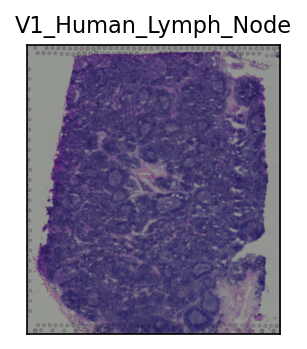

In [8]:
fig, ax = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adata, show=False, ax=ax, title=sample_id)
ax.set_xlabel("")
ax.set_ylabel("")

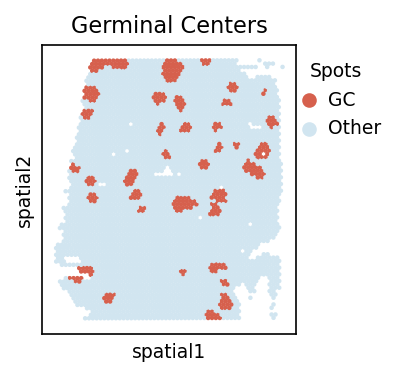

In [9]:
fig, axes = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adata_stan, color='germinal_center', size=1.8, alpha_img=0, 
              palette={"GC":'#d6604d', "Other":'#d1e5f0'},
              ax=axes, show=False, legend_fontsize=fontsize)
axes.set_title('Germinal Centers')
plt.legend(title="Spots", loc='upper right', bbox_to_anchor=(1.4, 1), columnspacing=0.5, handletextpad=0, frameon=False)

## Visualizing the cross validation performance

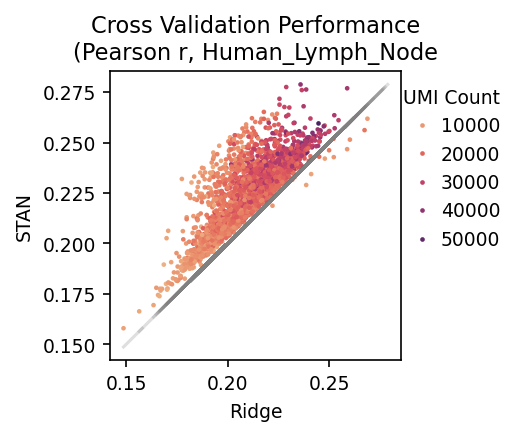

In [105]:
stan.plot_validation(adata_stan, title='Cross Validation Performance\n(Pearson r, Human_Lymph_Node')

In [11]:
wilcoxon(adata_stan.obs["pred_cor_stan"], adata_stan.obs["pred_cor_ridge"], 
         zero_method='wilcox', correction=False, alternative='greater')

WilcoxonResult(statistic=7947102.0, pvalue=0.0)

In [12]:
print(adata_stan.obs["pred_cor_stan"].mean())
print(adata_stan.obs["pred_cor_stan"].std())
print(adata_stan.obs["pred_cor_ridge"].mean())
print(adata_stan.obs["pred_cor_ridge"].std())

0.2242677756671426
0.014278275471356891
0.2113947286650381
0.013418704830793453


In [13]:
pearsonr(adata_stan.obs["pred_cor_stan"]-adata_stan.obs["pred_cor_ridge"],
         adata_stan.obs["n_counts"])

PearsonRResult(statistic=-0.05241759465232896, pvalue=0.0009267874671672197)

## Embedding and Clustering

### Clustering based on TF Activity
More than half germinal centers are in Cluster 0.

In [14]:
import sklearn
from sklearn.preprocessing import OrdinalEncoder
def compute_ari(adata, cluster_1, cluster_2, cluster1_target):
    label_1 = np.array(adata.obs[cluster_1]).reshape(-1,1)
    label_1[label_1!=cluster1_target]='0'
    sklearn_encoder = OrdinalEncoder()
    encoder_1 = sklearn_encoder.fit_transform(label_1)

    label_2 = np.array(adata.obs[cluster_2]).reshape(-1,1)
    sklearn_encoder = OrdinalEncoder()
    encoder_2 = sklearn_encoder.fit_transform(label_2)

    s = sklearn.metrics.adjusted_rand_score(encoder_1.flatten(), encoder_2.flatten())
    return s

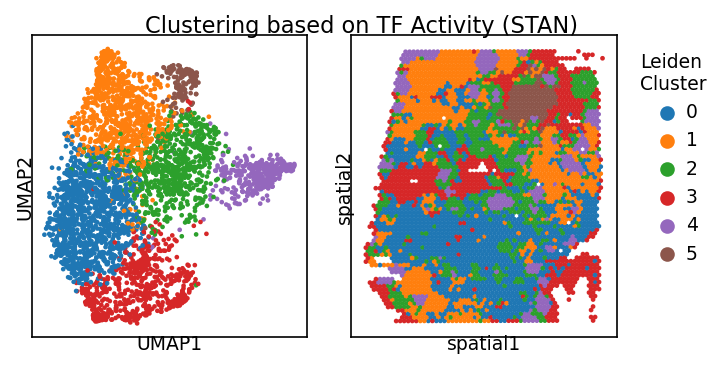

In [34]:
# adata_tfa_scaled = adata_tfa.copy()[:, adata_tfa.to_df().dropna(axis=1).columns]
# sc.pp.scale(adata_tfa_scaled)
# sc.pp.neighbors(adata_tfa_scaled, n_neighbors=100)
# sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_scaled, resolution=0.8)
stan.plot_umap(adata_tfa_scaled, title='Clustering based on TF Activity (STAN)')

In [35]:
for i in range(8):
    print(compute_ari(adata_tfa_scaled, 'leiden', 'germinal_center',str(i)))

0.0
-0.07962081948430288
-0.03633383859627217
-0.06424075454744252
0.7580794175072664
-0.02548374143139266
0.0
0.0


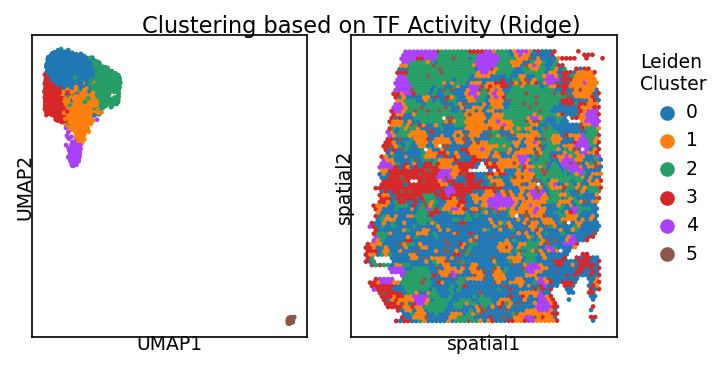

In [19]:
adata_tfa_ridge_scaled = adata_tfa_ridge.copy()
sc.pp.scale(adata_tfa_ridge_scaled)
sc.pp.neighbors(adata_tfa_ridge_scaled, n_neighbors=100)
sc.tl.umap(adata_tfa_ridge_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_ridge_scaled, resolution=0.8)
stan.plot_umap(adata_tfa_ridge_scaled, title='Clustering based on TF Activity (Ridge)')

In [20]:
compute_ari(adata_tfa_ridge_scaled, 'leiden', 'germinal_center','4')

0.704456416147693

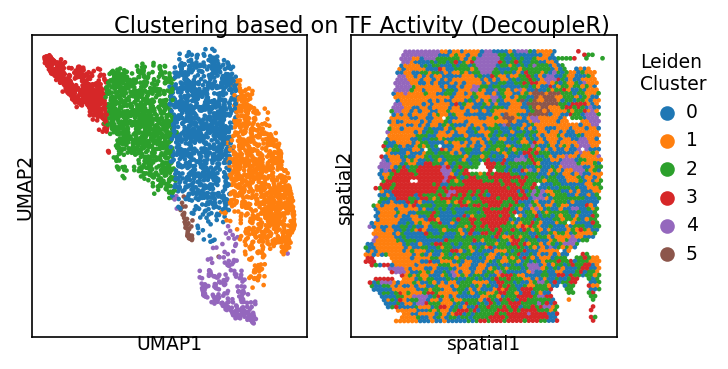

In [38]:
tfs = adata_tfa_dec.var_names.intersection(adata_stan.varm['gene_tf'].columns)
adata_dec_scaled = adata_tfa_dec.copy()[:, tfs]
sc.pp.scale(adata_dec_scaled)
sc.pp.neighbors(adata_dec_scaled, n_neighbors=100)
sc.tl.umap(adata_dec_scaled, min_dist=0.01)
sc.tl.leiden(adata_dec_scaled, resolution=0.835)
stan.plot_umap(adata_dec_scaled, title='Clustering based on TF Activity (DecoupleR)')

In [39]:
compute_ari(adata_dec_scaled, 'leiden', 'germinal_center','4')

0.6036837470323235

### Clustering based on mRNA expression
The spatial distribution based on mRNA expression is noisier and less precise.

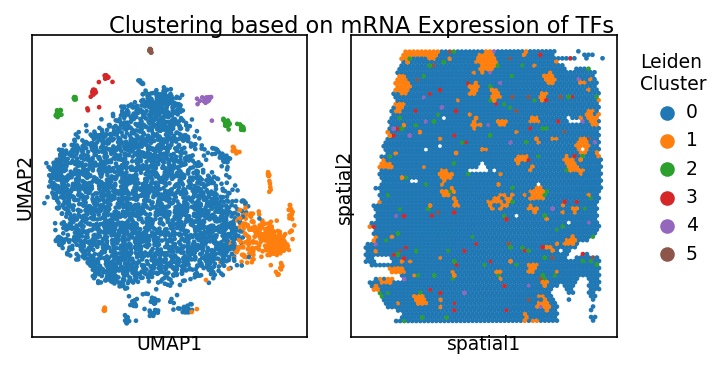

In [37]:
tfs = adata.var_names.intersection(adata_stan.varm['gene_tf'].columns)
adata_scaled = adata.copy()
sc.pp.log1p(adata_scaled)
sc.pp.scale(adata_scaled)
adata_scaled_subset = adata_scaled[:, tfs].copy()
sc.pp.neighbors(adata_scaled_subset, n_neighbors=100)
sc.tl.umap(adata_scaled_subset, min_dist=0.01)
sc.tl.leiden(adata_scaled_subset, resolution=0.5) # res = 1
stan.plot_umap(adata_scaled_subset, title='Clustering based on mRNA Expression of TFs')

In [24]:
compute_ari(adata_scaled_subset, 'leiden', 'germinal_center','3')

0.6256828032923115

In [40]:
df = pd.DataFrame(columns=['method', 'type', 'ari'])
df.loc[0,:] = ['STAN', 'TF Activity', 
               compute_ari(adata_tfa_scaled, 'leiden', 'germinal_center','4')]
df.loc[1,:] = ['Ridge', 'TF Activity', 
               compute_ari(adata_tfa_ridge_scaled, 'leiden', 'germinal_center','4')]
df.loc[2,:] = ['DecouplerR', 'TF Activity', 
               compute_ari(adata_dec_scaled, 'leiden', 'germinal_center','4')]
df.loc[3,:] = ['TF mRNA', 'mRNA Expression', 
               compute_ari(adata_scaled_subset, 'leiden', 'germinal_center','1')]

([0, 1, 2, 3],
 [Text(0, 0, 'STAN'),
  Text(0, 1, 'Ridge'),
  Text(0, 2, 'DecouplerR'),
  Text(0, 3, 'TF mRNA')])

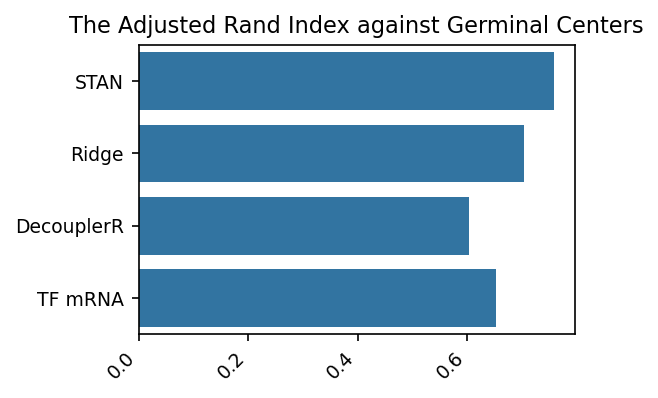

In [41]:
fig, axes = plt.subplots(1,1, figsize=(figsize*1.5, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
# sns.barplot(data=df, y="method", x="ari", hue="type", ax=axes)
sns.barplot(data=df, y="method", x="ari", ax=axes)
axes.set_title('The Adjusted Rand Index against Germinal Centers', fontsize=fontsize*1.2)
axes.set_ylabel('', fontsize=fontsize)
axes.set_xlabel('', fontsize=fontsize)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
# plt.legend(title="", bbox_to_anchor=(1.3,1), loc='upper right')

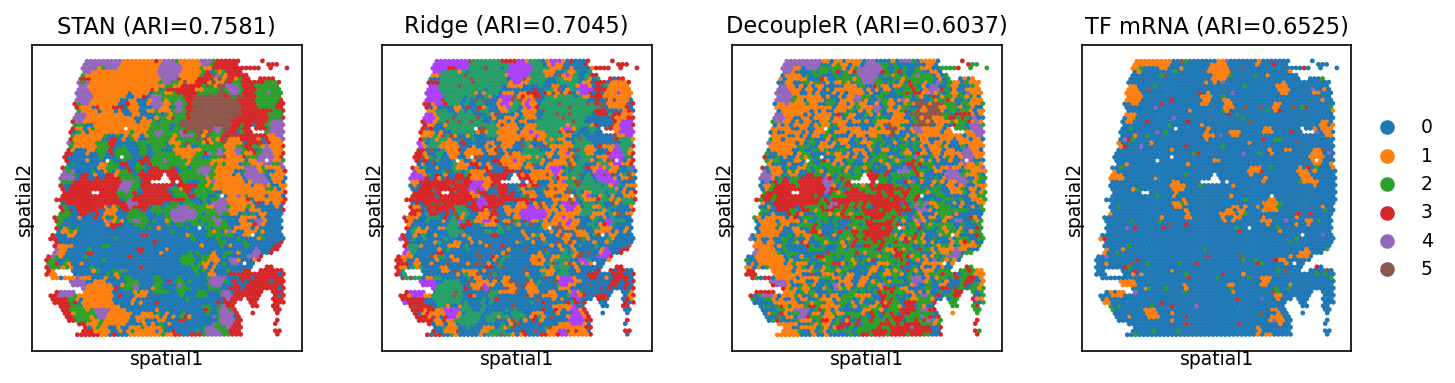

In [42]:
fig, axes = plt.subplots(1,4, figsize=(figsize*4, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 

i=0
sc.pl.spatial(adata_tfa_scaled, color="leiden", size=1.8, alpha_img=0, ax=axes[i], 
              show=False, frameon=True, legend_fontsize=fontsize)
axes[i].set_title(f"STAN (ARI={df.iloc[i,-1]:.4f})")

i=1
sc.pl.spatial(adata_tfa_ridge_scaled, color="leiden", size=1.8, alpha_img=0, ax=axes[i], 
              show=False, frameon=True, legend_fontsize=fontsize)
axes[i].set_title(f"Ridge (ARI={df.iloc[i,-1]:.4f})")

i=2
sc.pl.spatial(adata_dec_scaled, color="leiden", size=1.8, alpha_img=0, ax=axes[i], 
              show=False, frameon=True, legend_fontsize=fontsize)
axes[i].set_title(f"DecoupleR (ARI={df.iloc[i,-1]:.4f})")

i=3
sc.pl.spatial(adata_scaled_subset, color="leiden", size=1.8, alpha_img=0, ax=axes[i], 
              show=False, frameon=True, legend_fontsize=fontsize)
axes[i].set_title(f"TF mRNA (ARI={df.iloc[i,-1]:.4f})")

for i in range(4):
    axes[i].set_ylabel(axes[i].get_ylabel(),labelpad=-1)
    axes[i].set_xlabel(axes[i].get_xlabel(),labelpad=-1)
    
for i in range(3):
    axes[i].legend().remove()

plt.tight_layout(pad=0.6)

## Visualizing TFa in spatial coordinates
We rank TFs and genes for germinal centers and nongerminal centers.

In [43]:
def get_average_expression_by_group(adata):
    df = pd.DataFrame(adata.X, 
                  index=adata.obs['germinal_center'], 
                  columns=adata.var_names)

    # Compute mean by group
    average_expression = df.groupby(level=0).mean().T
    return average_expression['GC'] - average_expression['Other']

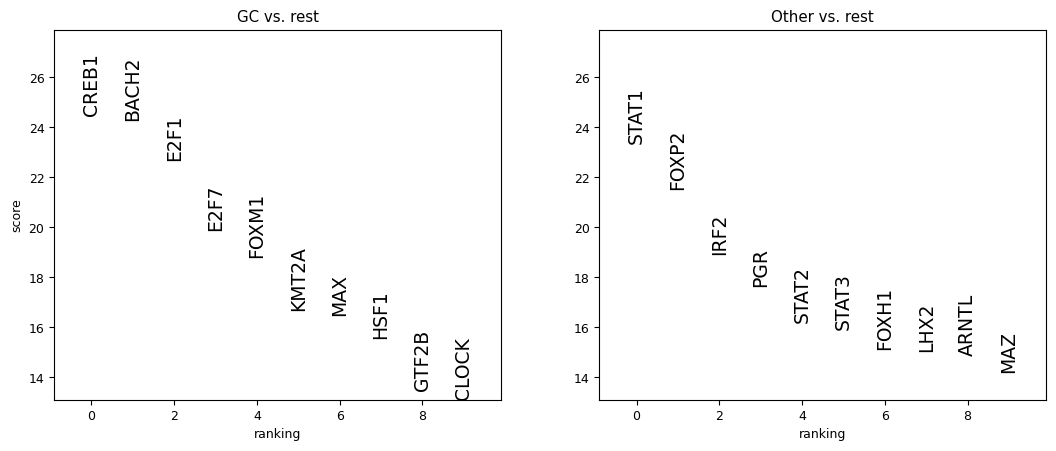

In [44]:
adata_tfa_scaled.obs['germinal_center'] = adata_tfa_scaled.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_tfa_scaled, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_tfa_scaled, fontsize=fontsize*1.5, n_genes=10)

In [45]:
df = sc.get.rank_genes_groups_df(adata_tfa_scaled, group='GC')
df = df.set_index('names')
df['diff'] = get_average_expression_by_group(adata_tfa_scaled)
df.to_csv('df2plot_inR/lymphnode_dat_of_gc_by_stan.csv')

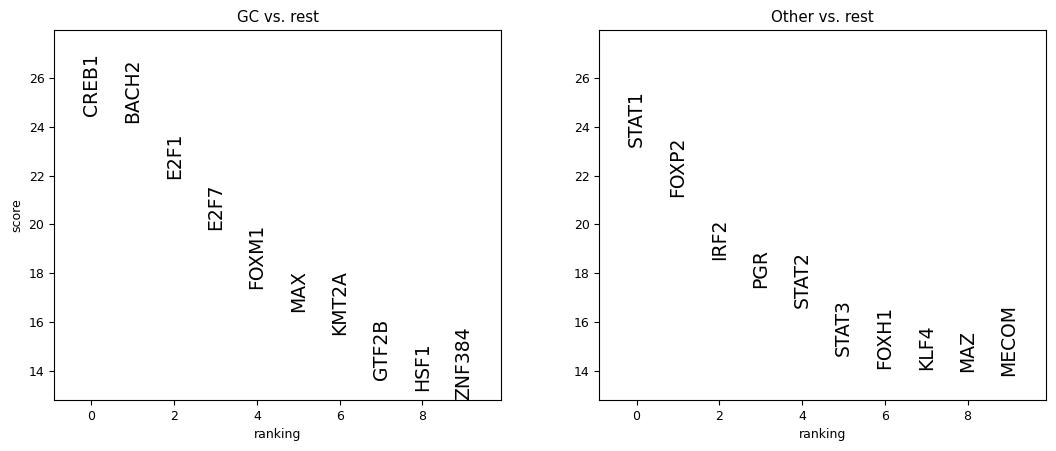

In [46]:
adata_tfa_ridge_scaled.obs['germinal_center'] = adata_tfa_ridge_scaled.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_tfa_ridge_scaled, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_tfa_ridge_scaled, fontsize=fontsize*1.5, n_genes=10)

In [47]:
df = sc.get.rank_genes_groups_df(adata_tfa_ridge_scaled, group='GC')
df = df.set_index('names')
df['diff'] = get_average_expression_by_group(adata_tfa_ridge_scaled)
df.to_csv('df2plot_inR/lymphnode_dat_of_gc_by_ridge.csv')

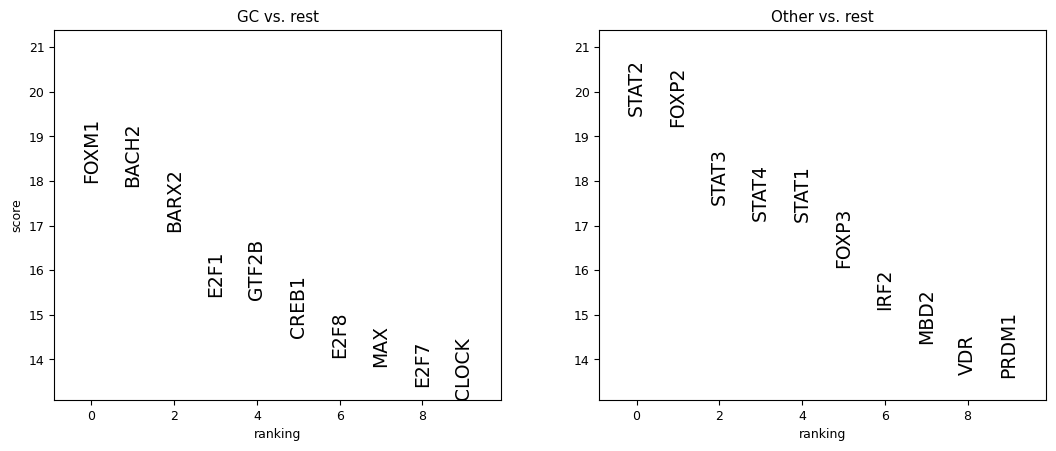

In [48]:
adata_dec_scaled.obs['germinal_center'] = adata_dec_scaled.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_dec_scaled, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_dec_scaled, fontsize=fontsize*1.5, n_genes=10)

In [49]:
df = sc.get.rank_genes_groups_df(adata_dec_scaled, group='GC')
df = df.set_index('names')
df['diff'] = get_average_expression_by_group(adata_dec_scaled)
df.to_csv('df2plot_inR/lymphnode_dat_of_gc_by_decoupler.csv')

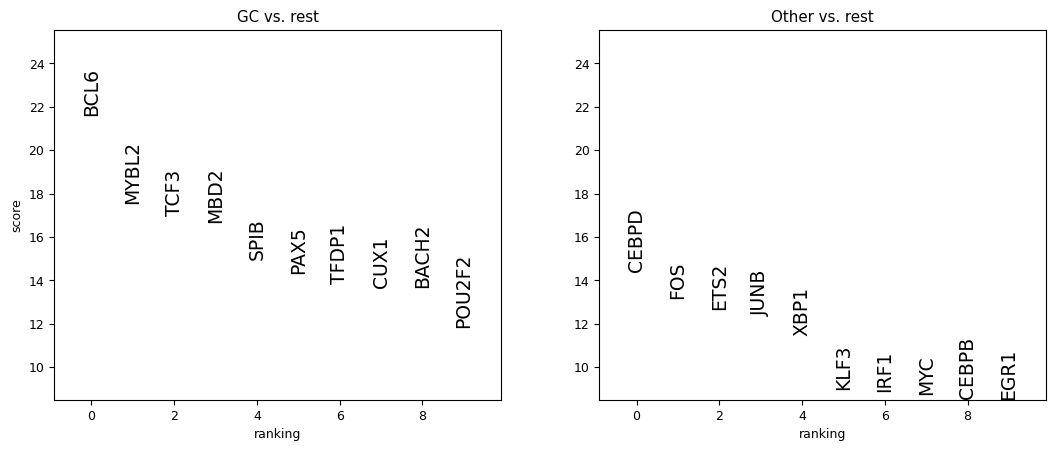

In [50]:
# sc.pp.log1p(adata)
adata_scaled_subset.obs['germinal_center'] = adata_scaled_subset.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_scaled_subset, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_scaled_subset, fontsize=fontsize*1.5, n_genes=10)

In [51]:
df = sc.get.rank_genes_groups_df(adata_scaled_subset, group='GC')
df = df.set_index('names')
df['diff'] = get_average_expression_by_group(adata_scaled_subset)
df.to_csv('df2plot_inR/lymphnode_deg_of_gc.csv')

Correlate TFs with GCs

In [52]:
target = ['BCL6', 'IRF4', 'PAX5', 'MYC', 'FOXP1', 'SPIB', 'RELA', 'TBX21']

In [53]:
sc.get.rank_genes_groups_df(adata_tfa_scaled, group='GC').query('names in @target')

names     scores  logfoldchanges         pvals     pvals_adj
21    PAX5  10.315347             NaN  6.006403e-25  2.868364e-24
33    SPIB   7.902467             NaN  2.734364e-15  7.998013e-15
36     MYC   7.405534             NaN  1.306234e-13  3.473396e-13
49   FOXP1   5.323595             NaN  1.017364e-07  2.137258e-07
70    BCL6   2.697547             NaN  6.985240e-03  9.906340e-03
114   IRF4  -0.751433             NaN  4.523923e-01  5.061029e-01
128   RELA  -1.785633             NaN  7.415876e-02  9.380081e-02
186  TBX21  -7.789161             NaN  6.745572e-15  1.901764e-14

In [54]:
sc.get.rank_genes_groups_df(adata_tfa_ridge_scaled, group='GC').query('names in @target')

names     scores  logfoldchanges         pvals     pvals_adj
14    PAX5  10.333495             NaN  4.971552e-25  2.982931e-24
29    SPIB   7.786500             NaN  6.889073e-15  2.238949e-14
34     MYC   6.932926             NaN  4.122251e-12  1.134831e-11
54   FOXP1   4.566651             NaN  4.955777e-06  9.505343e-06
66    BCL6   2.692511             NaN  7.091614e-03  1.050277e-02
110   IRF4  -0.676085             NaN  4.989866e-01  5.481824e-01
133   RELA  -2.109114             NaN  3.493474e-02  4.752749e-02
205  TBX21  -9.756558             NaN  1.729235e-22  8.430022e-22

In [55]:
sc.get.rank_genes_groups_df(adata_dec_scaled, group='GC').query('names in @target')

names    scores  logfoldchanges         pvals     pvals_adj
52   FOXP1  6.753536             NaN  1.442850e-11  3.751410e-11
64    PAX5  5.613441             NaN  1.983427e-08  4.257998e-08
72    BCL6  4.977025             NaN  6.456913e-07  1.238457e-06
81    SPIB  4.242932             NaN  2.206181e-05  3.740916e-05
93    IRF4  3.336434             NaN  8.486069e-04  1.272910e-03
112    MYC  2.179236             NaN  2.931416e-02  3.748368e-02
207   RELA -7.874533             NaN  3.420192e-15  1.159891e-14
213  TBX21 -9.514316             NaN  1.829125e-21  8.560305e-21

Find the edges of the germinal centers.

In [56]:
import auxiliary_lymphnode as auxln
points, edges = auxln.find_edges(adata)

We create spatial plots for inferred TF activity of the top 3 ranked TFs in the germinal centers.

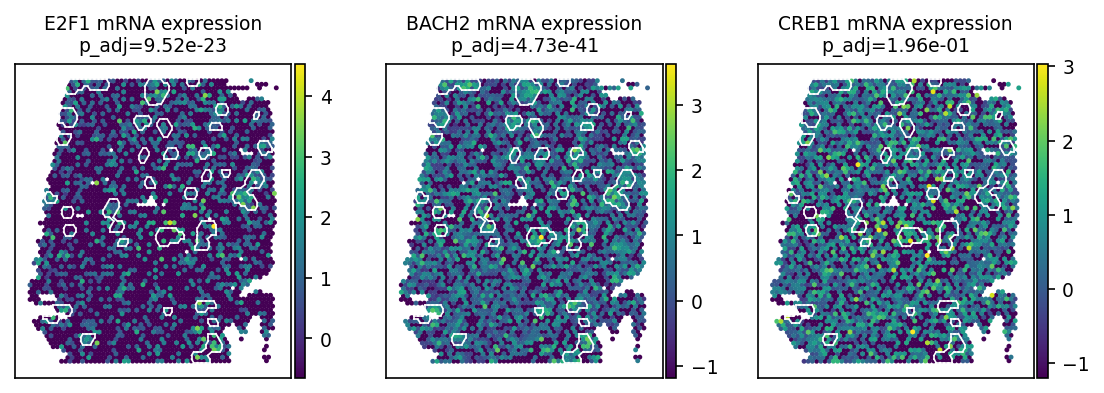

In [57]:
stan.plot_spatial_expression(adata_scaled_subset, ['E2F1', 'BACH2', 'CREB1'], points, edges)

In [58]:
def plot_spatial_activity(ad, genes, points, edges, method):
    df = sc.get.rank_genes_groups_df(ad, group='GC')
    df.index = df['names']

    ngenes = len(genes)
    fig, axs = plt.subplots(1, ngenes, figsize=(ngenes*figsize, figsize), dpi=dpi)
    plt.rc('font', size=fontsize) 
    for i in range(ngenes):
        tf = genes[i]
        sc.pl.spatial(ad, color=tf, 
            size=1.8, alpha_img=0, color_map="plasma", ax=axs[i], show=False, 
            legend_fontsize=fontsize, colorbar_loc='right')
        title = f'{method}-inferred {tf} activity\np_adj=%.2e'%df.loc[tf,'pvals_adj']
        axs[i].set_title(title, fontsize=fontsize)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        for ii, jj in edges:
            axs[i].plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=0.8)
    plt.tight_layout(pad=0.6)

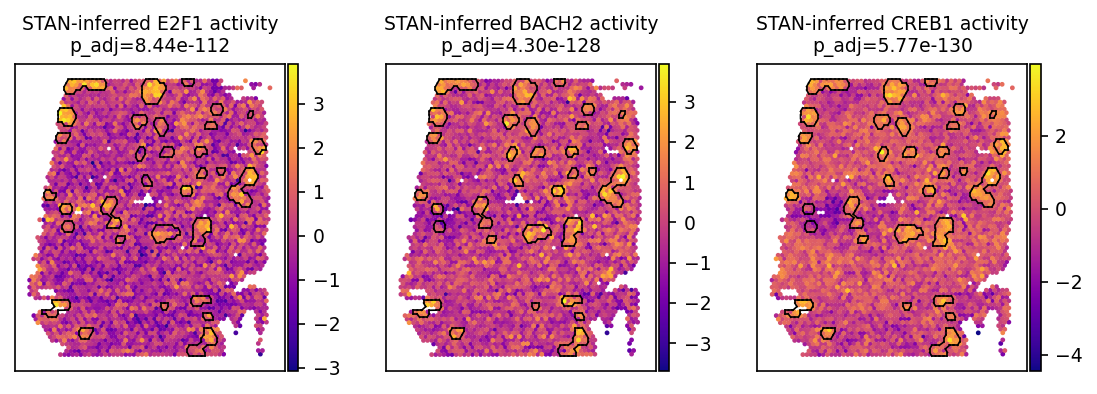

In [59]:
plot_spatial_activity(adata_tfa_scaled, ['E2F1', 'BACH2', 'CREB1'], points, edges, 'STAN')

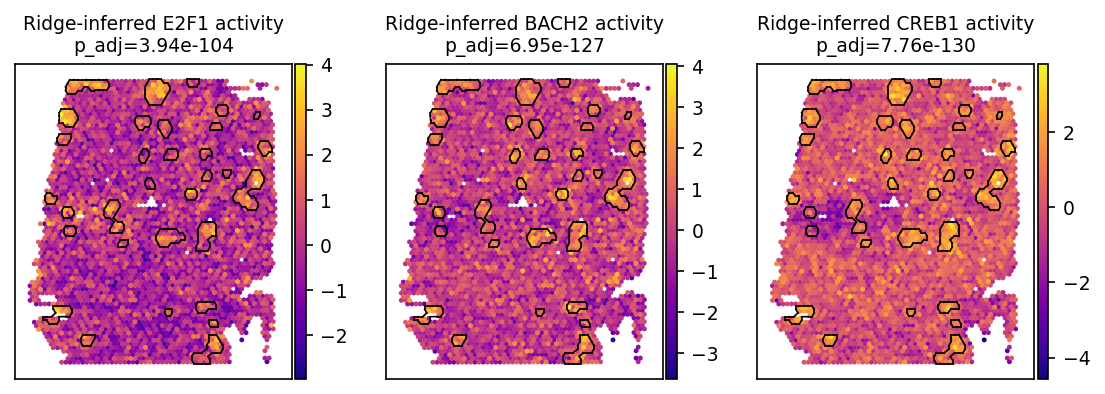

In [60]:
plot_spatial_activity(adata_tfa_ridge_scaled, ['E2F1', 'BACH2', 'CREB1'], points, edges, 'Ridge')

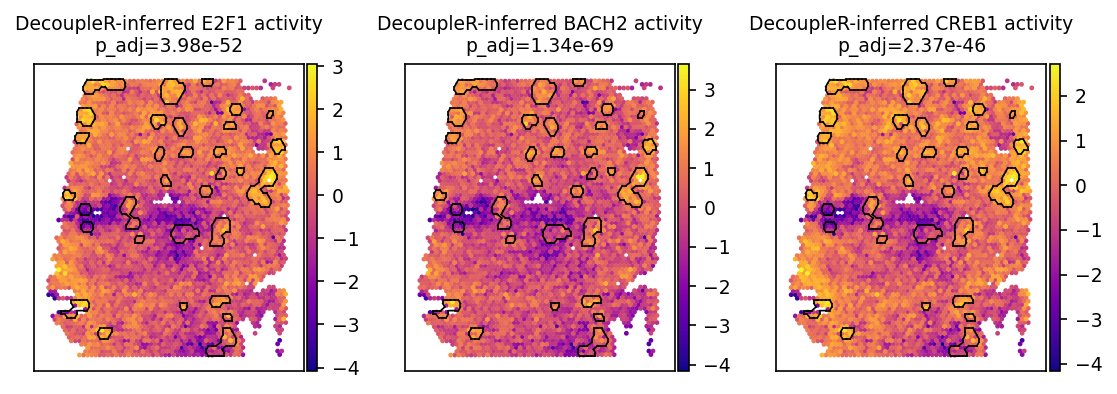

In [61]:
plot_spatial_activity(adata_dec_scaled, ['E2F1', 'BACH2', 'CREB1'], points, edges, 'DecoupleR')

## Celltype Proportion and TF Activity
Merge some celltype groups with small proportion.

In [62]:
# adata_raw = adata_smoothed.copy()
df_celltype = auxln.merge_celltypes(adata)
adata.obsm['celltype_major'] = df_celltype
adata_scaled_subset.obsm['celltype_major'] = df_celltype
adata_stan.obsm['celltype_major'] = df_celltype
adata_tfa_scaled.obsm['celltype_major'] = df_celltype  
adata_tfa_ridge_scaled.obsm['celltype_major'] = df_celltype  
adata_dec_scaled.obsm['celltype_major'] = df_celltype  

### Correlating celltype proportion with TF activity and mRNA expression

In [63]:
mat_cor_tfa, mat_cor_rna = auxln.make_cor_dataframe(adata_scaled_subset, adata_tfa_scaled, celltype_label='celltype_major')

In [72]:
mat_cor_tfa

B_Cycling      B_GC     B_IFN  B_activated     B_mem   B_naive  \
AHR     -0.102097 -0.020326 -0.037054     0.074373 -0.042343  0.092153   
AR      -0.066954  0.065854  0.028385     0.107641 -0.189109  0.084448   
ARID3A  -0.030768 -0.069425 -0.103991     0.087717  0.100423 -0.091712   
ARNT    -0.137456 -0.079659 -0.038709     0.149907 -0.033243  0.073437   
ARNTL   -0.291040 -0.246469 -0.039532     0.086283 -0.027511  0.034050   
...           ...       ...       ...          ...       ...       ...   
ZNF281   0.031067 -0.044901  0.079761    -0.058083  0.113437 -0.101693   
ZNF384   0.226135  0.234580 -0.047050    -0.047354  0.015917  0.064649   
ZNF711  -0.087938 -0.001868 -0.019297     0.104154  0.058606  0.161587   
ZNF76   -0.029783 -0.037185 -0.099720     0.199395  0.089773  0.046803   
ZNF84    0.129564  0.132272  0.074533    -0.264114 -0.219864  0.066859   

        B_plasma   B_preGC        DC      Endo  ...      Mast  Monocytes  \
AHR     0.034891 -0.081204 -0.101271  0.011030  ... -0.005209   0.023097   
AR      0.078589 -0.207016 -0.139394  0.064907  ... -0.034812   0.062614   
ARID3A  0.072238  0.038752  0.174652  0.239493  ...  0.106385   0.170076   
ARNT    0.152093 -0.063036 -0.073578  0.083730  ...  0.020014   0.080451   
ARNTL   0.106428 -0.012229 -0.022414  0.119008  ... -0.012545   0.078082   
...          ...       ...       ...       ...  ...       ...        ...   
ZNF281 -0.049714  0.175469  0.140633  0.047035  ...  0.026828   0.035992   
ZNF384 -0.104633 -0.038949 -0.053986 -0.185239  ... -0.036242  -0.142684   
ZNF711  0.036975 -0.005393 -0.119711  0.062168  ...  0.021204   0.032738   
ZNF76   0.109913  0.042814  0.047249  0.223039  ...  0.085315   0.153532   
ZNF84  -0.278884 -0.087920 -0.133580 -0.344317  ... -0.188902  -0.345793   

              NK       NKT    T_CD4+    T_CD8+    T_Treg   T_TIM3+     T_TfR  \
AHR     0.089025 -0.013991 -0.003998  0.088337  0.076193  0.025360  0.035782   
AR      0.212836 -0.002376 -0.039100  0.151196  0.125108  0.047526  0.044318   
ARID3A -0.034012  0.145580 -0.062642 -0.071658 -0.099093 -0.085962 -0.070475   
ARNT    0.103015  0.041077 -0.030106  0.080790  0.041182  0.022486 -0.024086   
ARNTL   0.091138  0.073643  0.099247  0.202118  0.180781  0.040743  0.136756   
...          ...       ...       ...       ...       ...       ...       ...   
ZNF281 -0.125027  0.064579 -0.034451 -0.133152 -0.116355 -0.000399 -0.010495   
ZNF384 -0.067837 -0.087927 -0.075340 -0.148217 -0.115899 -0.042307 -0.104071   
ZNF711  0.082608 -0.004433 -0.155400 -0.066577 -0.073124  0.061135 -0.073501   
ZNF76   0.050939  0.125532 -0.189086 -0.098426 -0.158457 -0.005130 -0.180016   
ZNF84   0.002540 -0.296715  0.218319  0.149597  0.265490  0.104337  0.229168   

            VSMC  
AHR     0.014516  
AR      0.036584  
ARID3A  0.183031  
ARNT    0.128082  
ARNTL   0.136984  
...          ...  
ZNF281  0.099673  
ZNF384 -0.187240  
ZNF711  0.094191  
ZNF76   0.149188  
ZNF84  -0.388953  

[234 rows x 23 columns]

In [83]:
mat_cor_tfa['B_GC'].sort_values()

STAT1   -0.466436
FOXP2   -0.385886
MAZ     -0.334420
PGR     -0.323757
IRF2    -0.308609
           ...   
MAX      0.286330
E2F7     0.318325
E2F1     0.379638
BACH2    0.526913
CREB1    0.533061
Name: B_GC, Length: 234, dtype: float64

In [64]:
mat_cor_tfa.to_csv('mat_cor_tfa_stan.csv')

In [65]:
def plot_spatial_ct_tf(ct, tf):
    fig, axs = plt.subplots(1,3, figsize=(figsize*3,figsize), dpi=300)
    sc.pl.spatial(sq.pl.extract(adata_tfa_scaled, "celltype_major"),
                  color=ct, alpha_img=0, ax=axs[0], show=False, cmap="rocket", size=1.8,
                  legend_fontsize=fontsize)
    sc.pl.spatial(adata_scaled_subset, color=tf, alpha_img=0, ax=axs[1],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_tfa_scaled, color=tf, alpha_img=0, ax=axs[2],show=False, cmap="plasma", 
                  legend_fontsize=fontsize, size=1.8)

    axs[0].set_title(f'{ct} proportion', fontsize=fontsize)
    axs[1].set_title(f"{tf} mRNA expression\nPearson r={mat_cor_rna.loc[tf, ct]:.4f}", fontsize=fontsize)
    axs[2].set_title(f'STAN-inferred {tf} activity\nPearson r={mat_cor_tfa.loc[tf, ct]:.4f}', fontsize=fontsize)
    
    for i in range(3):
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    plt.tight_layout(pad=0.6)

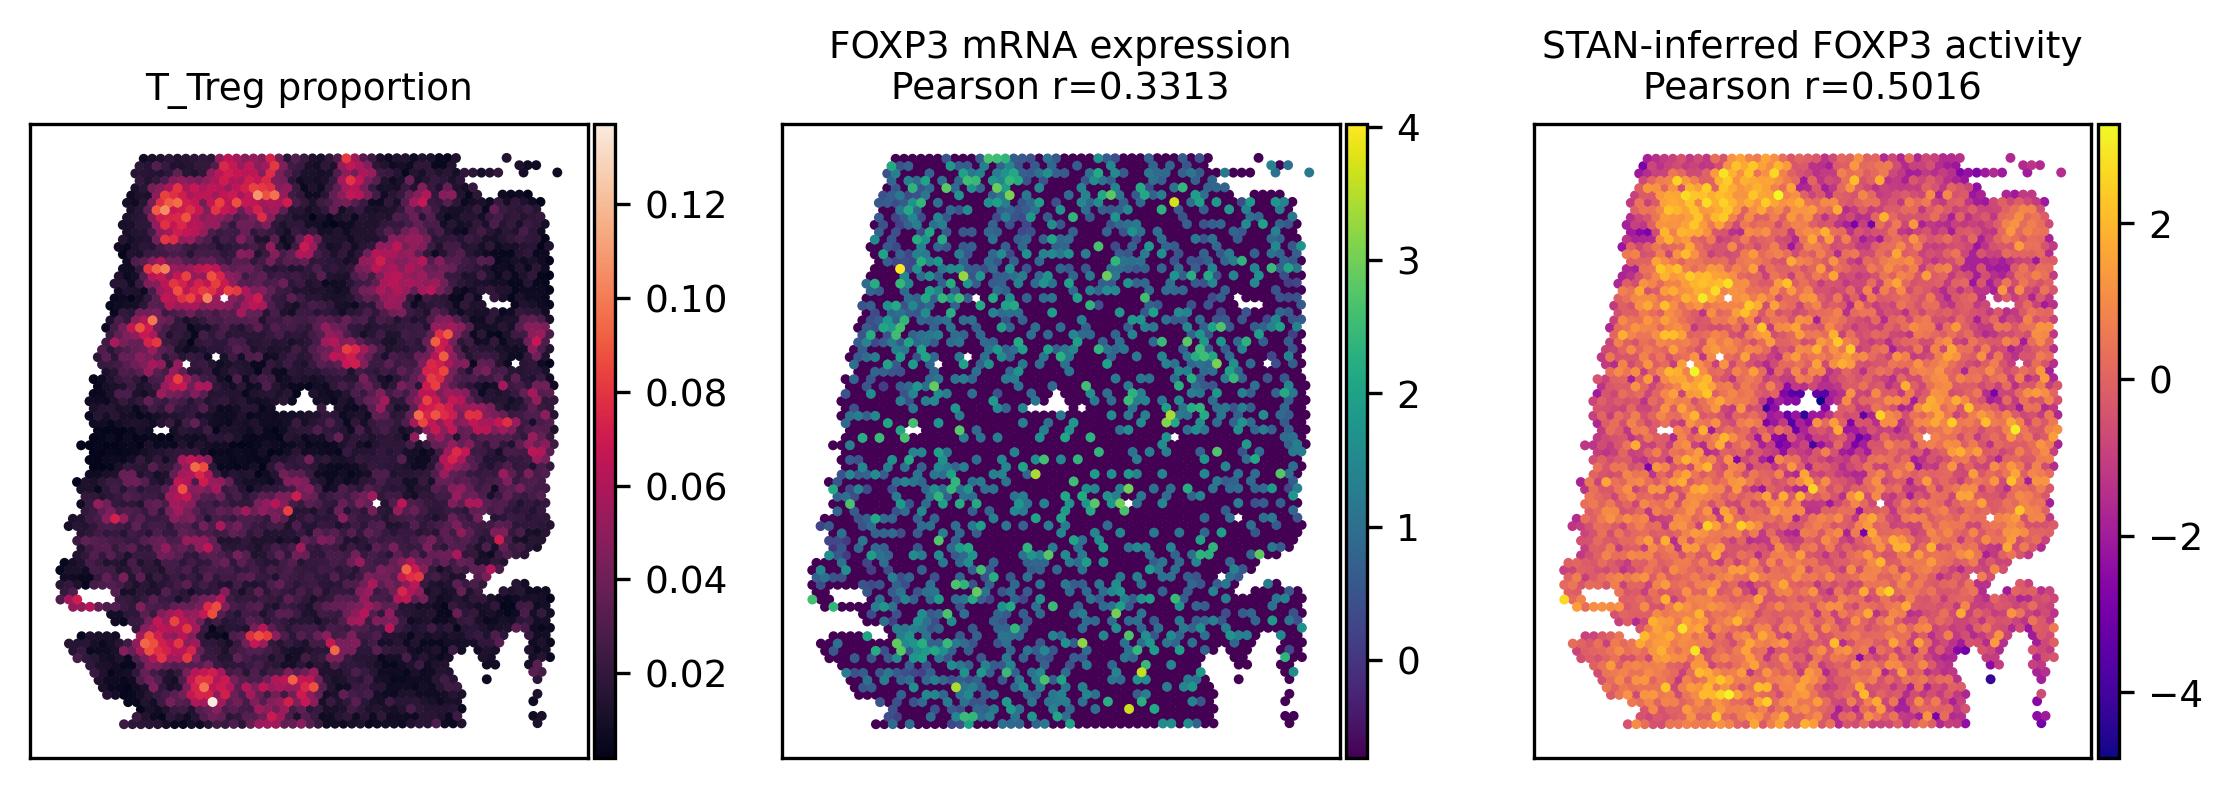

In [66]:
plot_spatial_ct_tf(ct = "T_Treg", tf = "FOXP3")

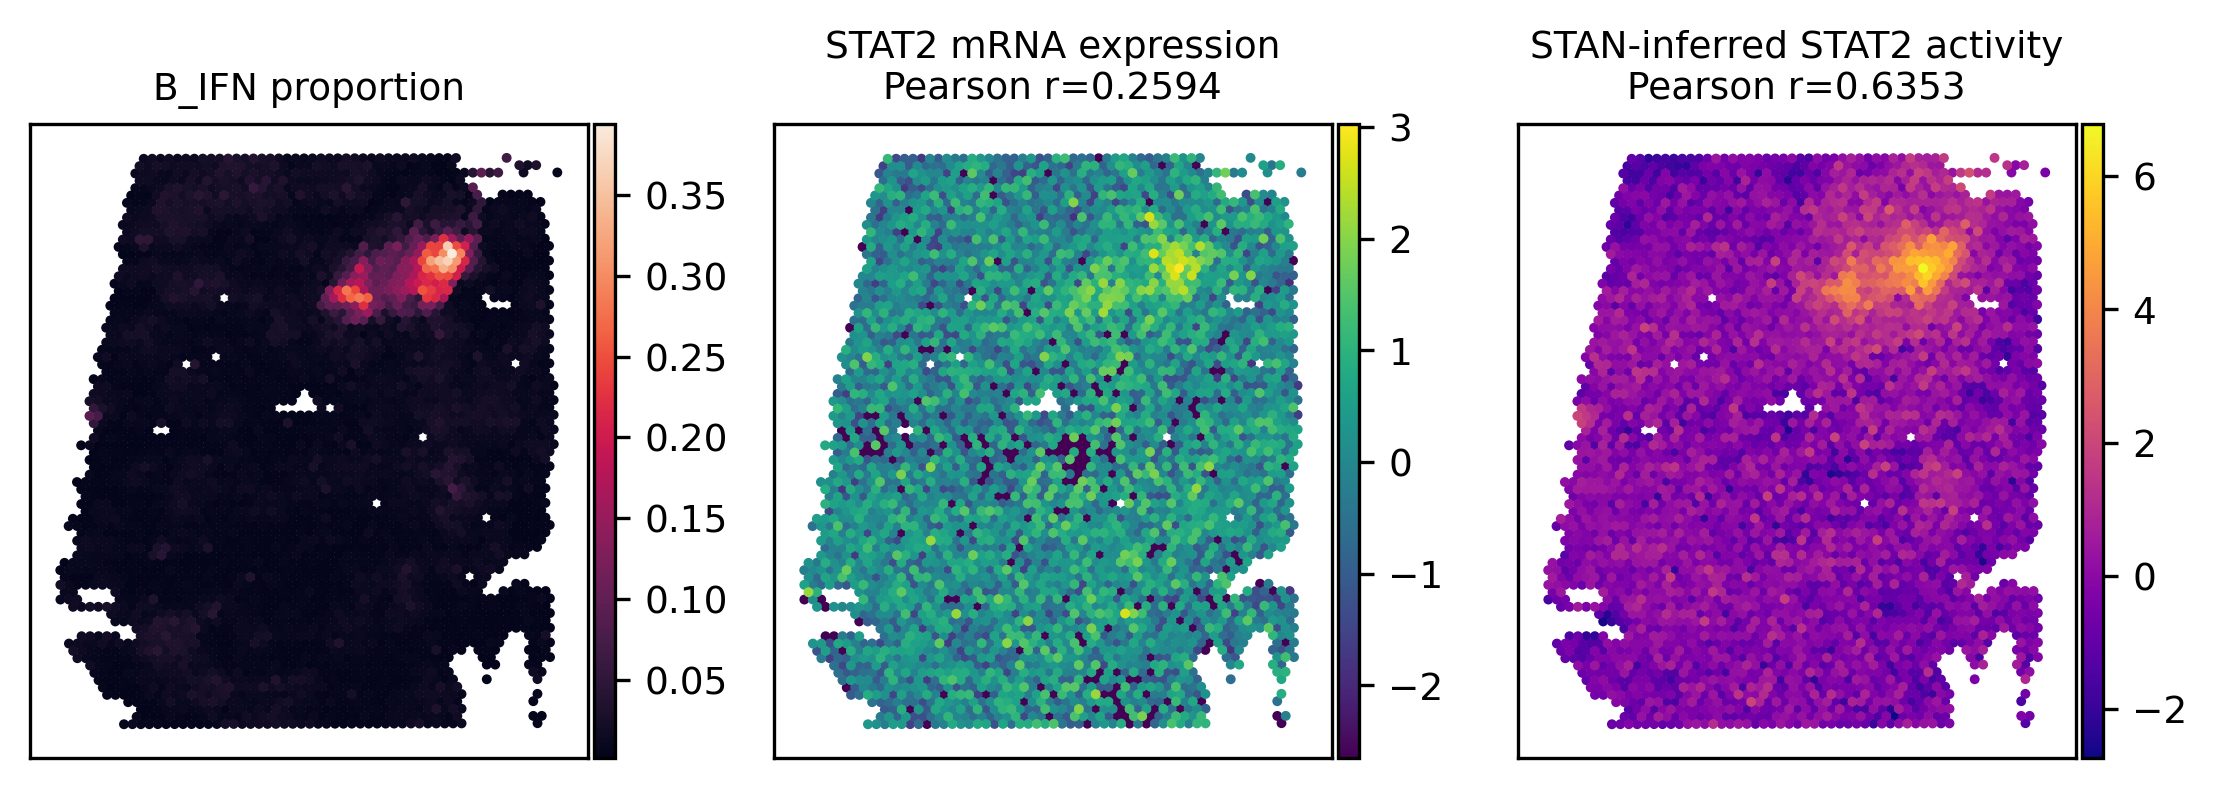

In [67]:
plot_spatial_ct_tf(ct = "B_IFN", tf = "STAT2")

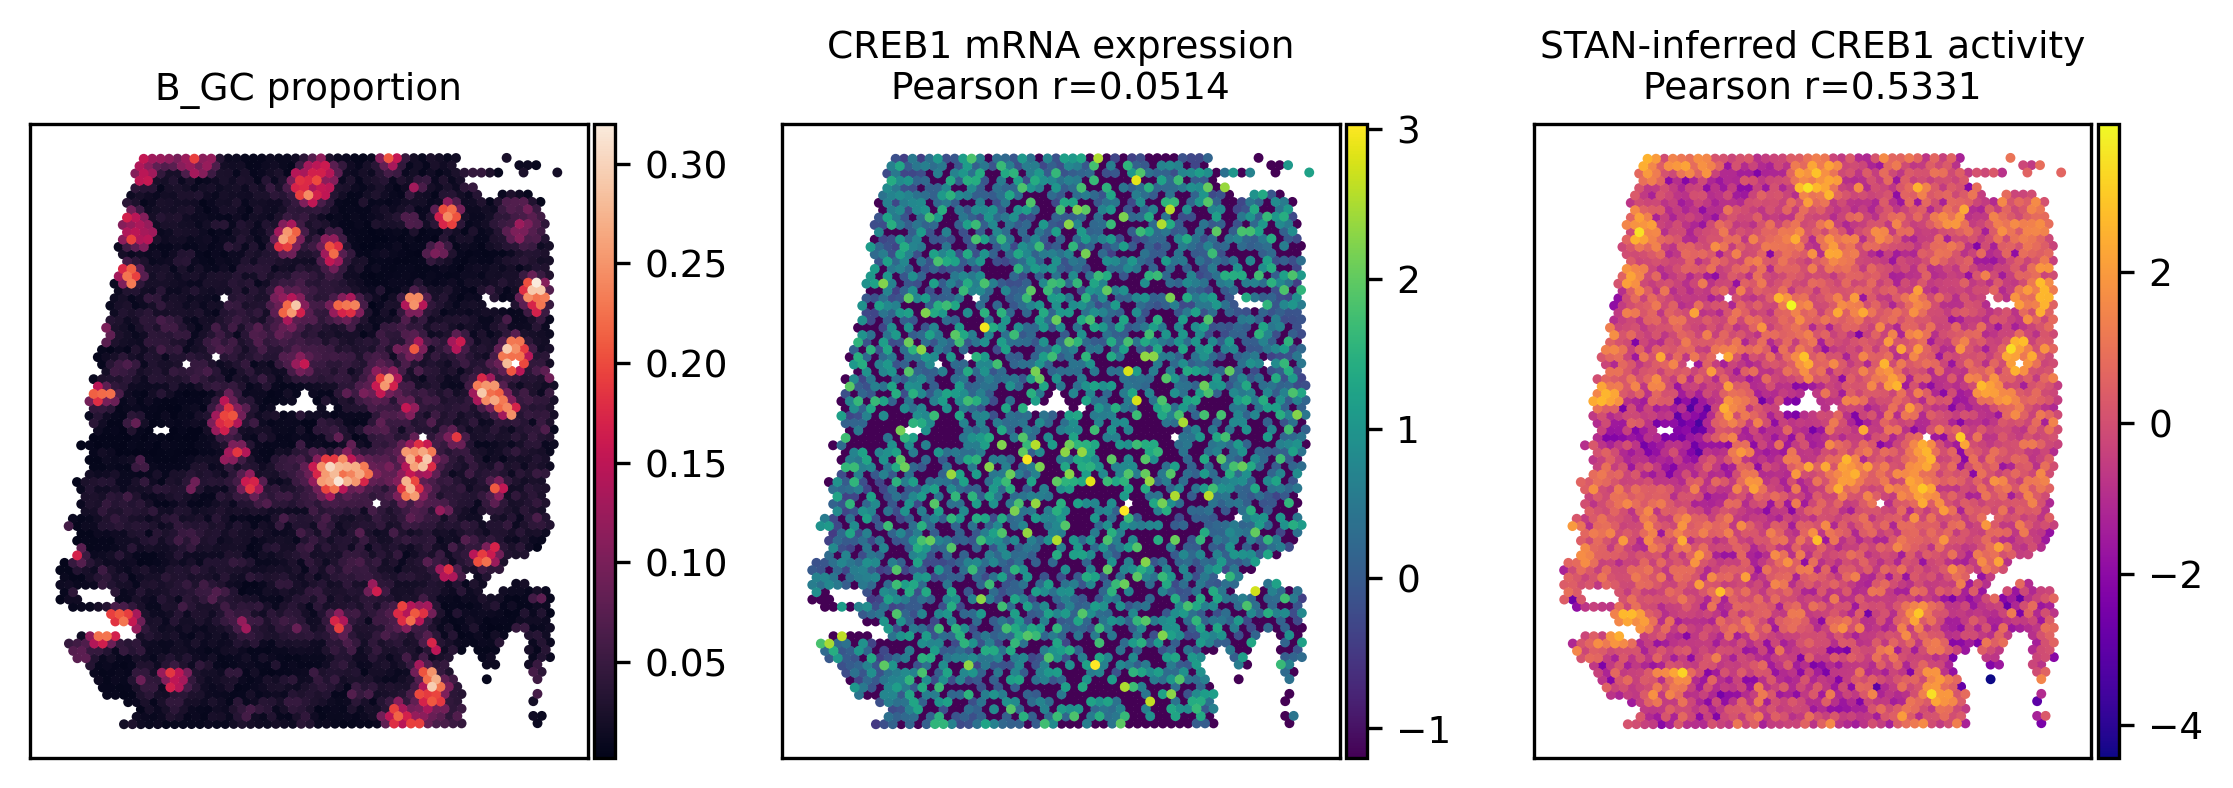

In [85]:
plot_spatial_ct_tf(ct = "B_GC", tf = "CREB1")

In [86]:
def plot_spatial_ct_tf(ad, ct, tf, method):
    mat_cor_tfa_ridge, mat_cor_rna = auxln.make_cor_dataframe(adata_scaled_subset, ad, celltype_label='celltype_major')
    mat_cor_tfa_ridge.to_csv(f'mat_cor_tfa_{method}.csv')
    fig, axs = plt.subplots(1,1, figsize=(figsize*1,figsize), dpi=dpi)
    sc.pl.spatial(ad, color=tf, alpha_img=0,show=False, ax = axs, cmap="plasma", 
                  legend_fontsize=fontsize, size=1.8)

    axs.set_title(f'{method}-inferred {tf} activity\nPearson r={mat_cor_tfa_ridge.loc[tf, ct]:.4f}', fontsize=fontsize)
    axs.set_xlabel("")
    axs.set_ylabel("")
    plt.tight_layout(pad=0.6)

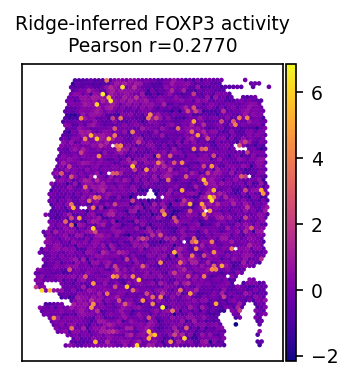

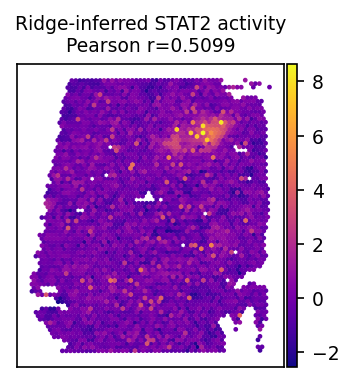

In [87]:
plot_spatial_ct_tf(adata_tfa_ridge_scaled, ct = "T_Treg", tf = "FOXP3", method='Ridge')
plot_spatial_ct_tf(adata_tfa_ridge_scaled, ct = "B_IFN", tf = "STAT2", method='Ridge')

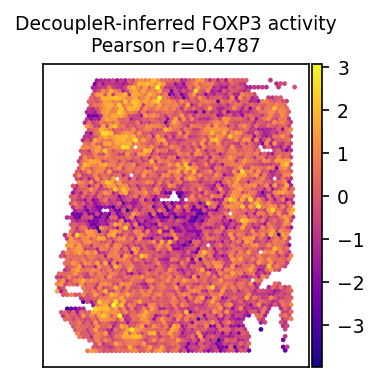

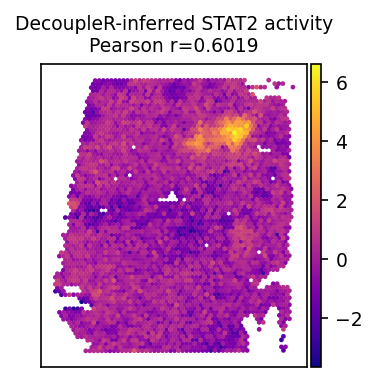

In [88]:
plot_spatial_ct_tf(adata_dec_scaled, ct = "T_Treg", tf = "FOXP3", method='DecoupleR')
plot_spatial_ct_tf(adata_dec_scaled, ct = "B_IFN", tf = "STAT2", method='DecoupleR')

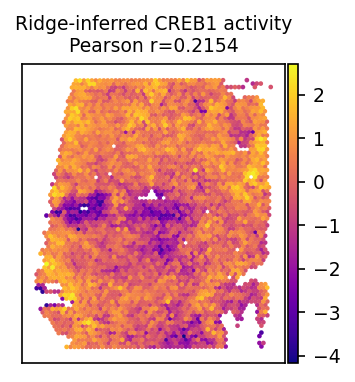

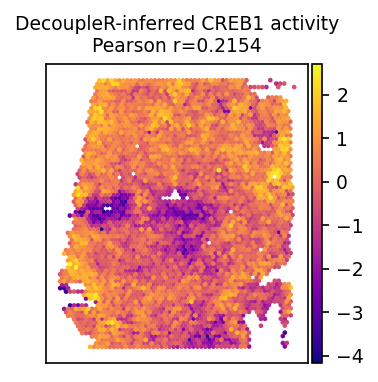

In [90]:
plot_spatial_ct_tf(adata_dec_scaled, ct = "B_GC", tf = "CREB1", method='Ridge')
plot_spatial_ct_tf(adata_dec_scaled, ct = "B_GC", tf = "CREB1", method='DecoupleR')

### Computing celltype-specific TF activity scores

In [91]:
def plot_heatmap(df_ct_tf, tf_list, ct_list, clip=10):
    data = df_ct_tf.query("tf in @tf_list and ct in @ct_list")
    data.columns = ['tf', 'ct', 'Cell type-specific TF Score', 'pval', 'p_adj', '-log(p_adj)']
    x = 'tf'
    y = 'ct'
    hue = 'Cell type-specific TF Score'

    data[x] = data[x].astype("category")
    data[y] = data[y].astype("category")
    x_lab = data[x].cat.categories
    y_lab = data[y].cat.categories

    f = sns.clustermap(data.pivot(index=y, columns=x, values=hue),figsize=(0.1,0.1), cmap='PiYG')
    x_lab = x_lab[f.dendrogram_col.reordered_ind]
    y_lab = y_lab[f.dendrogram_row.reordered_ind]
    print(x_lab)
    print(y_lab)

    data[x] = data[x].cat.reorder_categories(x_lab)
    data[y] = data[y].cat.reorder_categories(y_lab)
    data = data.sort_values([x, y])
    data[hue] = data[hue].clip(-clip, clip)

    figsize = 0.2
    plt.figure(figsize=(figsize*len(x_lab), figsize*len(y_lab)), dpi=dpi)
    plt.rc('font', size=fontsize) 
    ax = sns.scatterplot(data=data,x=x, y=y, palette="PiYG_r", hue=hue, size="-log(p_adj)")
    plt.legend(bbox_to_anchor=(1.5,1.), loc='upper right', 
        columnspacing=0.5, handletextpad=0, frameon=False, fontsize=fontsize)

    ax.set_xticklabels(x_lab, rotation = 90)
    ax.set_xlim(-0.5, -0.5+len(x_lab))
    ax.set_ylim(-0.5, -0.5+len(y_lab))
    ax.set_xlabel("")
    ax.set_ylabel("")

In [95]:
from scipy.stats import t
from statsmodels.stats.multitest import multipletests
def infer_celltype_activity(adata):
    A = adata.obsm['celltype_major'].to_numpy()
    b = adata.to_df().to_numpy()
    cov = np.dot(b.T - b.mean(), A - A.mean(axis=0)) / (b.shape[0]-1)
    ssd = np.std(A, axis=0, ddof=1) * np.std(b, axis=0, ddof=1).reshape(-1, 1)
    r = cov / ssd

    n_samples = b.shape[1]
    n_features, n_fsets = A.shape
    df = n_features - 2
    es = r * np.sqrt(df / ((1.0 - r + 1.0e-16)*(1.0 + r + 1.0e-16)))

    pv = t.sf(abs(es), df) * 2

    cts = adata.obsm['celltype_major'].columns
    tfs = adata.to_df().columns

    estimate = pd.DataFrame(es, index=tfs, columns=cts)
    estimate.name = 'coef'
    pvals = pd.DataFrame(pv, index=tfs, columns=cts)
    pvals.name = 'pvals'
    
    df_1 = estimate.stack().reset_index()
    df_1.columns = ['tf', 'ct', 'coef']
    
    df_2 = pvals.stack().reset_index()
    df_2.columns = ['tf', 'ct', 'pval']
    
    df_ct_tf = pd.merge(df_1, df_2, on=['tf', 'ct'])
    df_ct_tf["p_adj"] = multipletests(df_ct_tf['pval'], alpha=0.01, method="fdr_bh")[1]
    df_ct_tf["neg_log_p_adj"] = -np.log10(df_ct_tf["p_adj"]+1e-100)
    return df_ct_tf

Select TFs and celltypes for visualization.

In [96]:
df_ct_tf = auxln.infer_celltype_activity(adata_tfa_scaled)

In [97]:
df_ct_tf

tf           ct       coef           pval          p_adj  \
0       AHR    B_Cycling  -6.482160   1.014509e-10   2.882834e-10   
1       AHR         B_GC  -1.284043   1.992014e-01   2.360937e-01   
2       AHR        B_IFN  -2.341876   1.923607e-02   2.639687e-02   
3       AHR  B_activated   4.710361   2.556985e-06   5.319556e-06   
4       AHR        B_mem  -2.676751   7.464423e-03   1.083428e-02   
...     ...          ...        ...            ...            ...   
5377  ZNF84       T_CD8+   9.555906   2.073561e-21   1.035242e-20   
5378  ZNF84       T_Treg  17.392435   2.302639e-65   5.364850e-64   
5379  ZNF84      T_TIM3+   6.625946   3.911289e-11   1.137868e-10   
5380  ZNF84        T_TfR  14.869840   1.022379e-48   1.471241e-47   
5381  ZNF84         VSMC -26.666551  2.638277e-144  3.155380e-142   

      neg_log_p_adj  
0          9.540180  
1          0.626916  
2          1.578448  
3          5.274125  
4          1.965200  
...             ...  
5377      19.984958  
5378      63.270442  
5379       9.943908  
5380      46.832316  
5381     100.000000  

[5382 rows x 6 columns]

In [98]:
# df_filtered = df_ct_tf.query("negative_log_p_adj>2.8").query("coef>4 | coef < -4").query("r_squared>0.095")
df_filtered = df_ct_tf.query("neg_log_p_adj>5").query("coef>20")
tf_list = df_filtered['tf'].unique()
ct_list = df_filtered['ct'].unique()
print(tf_list)
print(ct_list)
df_ct_tf.query("tf in @tf_list and ct in @ct_list").to_csv('df2plot_inR/lymphnode_tf_by_celltype.csv')

['ATF5' 'BACH2' 'CREB1' 'CREB3' 'E2F1' 'E2F7' 'ELK3' 'ETV4' 'ETV6' 'FOXM1'
 'FOXP2' 'FOXP3' 'GTF2B' 'HNF1B' 'HSF1' 'IRF2' 'JUND' 'KLF1' 'KMT2A'
 'LEF1' 'LHX2' 'MAFB' 'MAX' 'MAZ' 'MYB' 'NFYC' 'PBX1' 'RFX3' 'SOX2'
 'STAT1' 'STAT2' 'STAT3' 'STAT4' 'STAT5B' 'STAT6' 'TBX21' 'TCF21' 'ZFHX3']
['B_activated' 'B_Cycling' 'B_GC' 'FDC' 'T_CD8+' 'T_Treg' 'Endo'
 'B_plasma' 'Monocytes' 'B_mem' 'DC' 'T_CD4+' 'T_TfR' 'B_preGC' 'B_IFN'
 'NK' 'NKT' 'VSMC' 'Macrophages' 'B_naive']


Index(['STAT3', 'FOXP2', 'STAT1', 'MAZ', 'LHX2', 'ELK3', 'TCF21', 'SOX2',
       'HNF1B', 'ETV6', 'NFYC', 'RFX3', 'ETV4', 'MAFB', 'ATF5', 'PBX1',
       'BACH2', 'CREB1', 'HSF1', 'FOXM1', 'KMT2A', 'E2F1', 'MAX', 'GTF2B',
       'E2F7', 'LEF1', 'KLF1', 'STAT4', 'STAT6', 'CREB3', 'FOXP3', 'MYB',
       'ZFHX3', 'STAT5B', 'TBX21', 'JUND', 'IRF2', 'STAT2'],
      dtype='object')
Index(['B_Cycling', 'B_GC', 'FDC', 'B_IFN', 'T_CD8+', 'T_Treg', 'T_CD4+',
       'T_TfR', 'B_naive', 'NK', 'B_activated', 'B_plasma', 'Macrophages',
       'Endo', 'Monocytes', 'NKT', 'VSMC', 'B_mem', 'B_preGC', 'DC'],
      dtype='object')


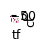

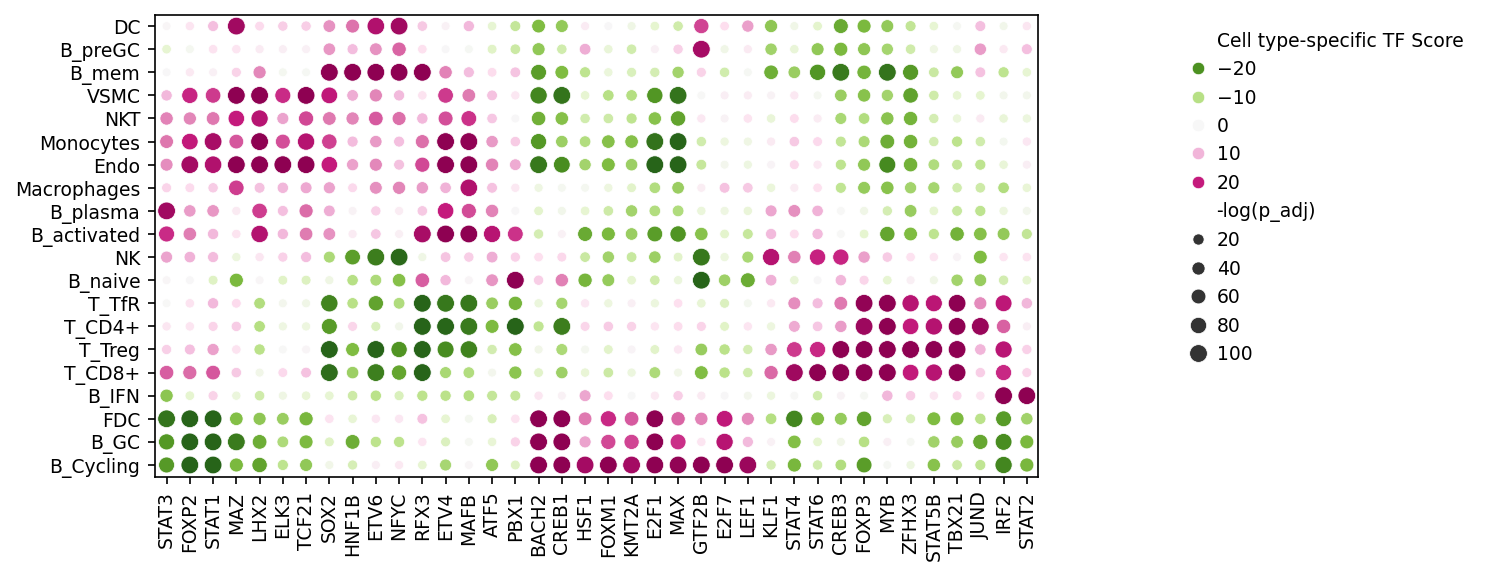

In [99]:
plot_heatmap(df_ct_tf, tf_list, ct_list, clip=25)

In [100]:
df_ct_tf_mrna = auxln.infer_celltype_activity(adata_scaled_subset)
df_ct_tf_mrna.query("tf in @tf_list and ct in @ct_list").to_csv('df2plot_inR/lymphnode_mrna_by_celltype.csv')

In [101]:
df_ct_tf_ridge = auxln.infer_celltype_activity(adata_tfa_ridge_scaled)
df_ct_tf_ridge.query("tf in @tf_list and ct in @ct_list").to_csv('df2plot_inR/lymphnode_tf_by_celltype_ridge.csv')

In [102]:
df_ct_tf_dec = auxln.infer_celltype_activity(adata_dec_scaled)
df_ct_tf_dec.query("tf in @tf_list and ct in @ct_list").to_csv('df2plot_inR/lymphnode_tf_by_celltype_decoupler.csv')

In [103]:
df_filtered = df_ct_tf_mrna.query("neg_log_p_adj>3").query("coef>20")
tf_list = np.intersect1d(df_filtered['tf'].unique(), adata_stan.to_df().columns)
ct_list = df_filtered['ct'].unique()
print(tf_list)
print(ct_list)


['BCL6' 'CEBPD' 'ETS2' 'FOXP3' 'LEF1' 'MYBL2' 'SPIB' 'STAT1' 'TCF3' 'XBP1']
['B_IFN' 'T_TfR' 'B_Cycling' 'B_GC' 'FDC' 'T_CD4+' 'T_CD8+' 'T_Treg'
 'Endo' 'B_activated' 'B_plasma' 'ILC' 'Monocytes' 'NK']


Index(['SPIB', 'BCL6', 'MYBL2', 'TCF3', 'LEF1', 'FOXP3', 'STAT1', 'XBP1',
       'CEBPD', 'ETS2'],
      dtype='object')
Index(['FDC', 'B_Cycling', 'B_GC', 'B_plasma', 'B_activated', 'ILC', 'NK',
       'Endo', 'Monocytes', 'B_IFN', 'T_CD8+', 'T_Treg', 'T_CD4+', 'T_TfR'],
      dtype='object')


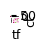

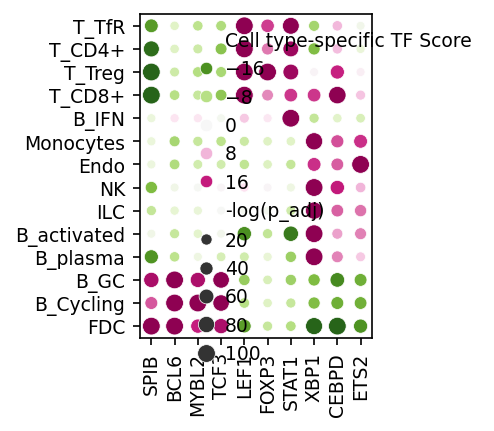

In [104]:
plot_heatmap(df_ct_tf_mrna, tf_list, ct_list, clip=20)